# 🤖 Machine Learning Models

**NYC Taxi Data Engineering Project - Microsoft Fabric**

This notebook builds three ML models with experiment tracking and versioning:

1. **Fare Prediction** (Regression) - Predict fare amount
2. **Tip Classification** (Classification) - Predict high tip probability
3. **Demand Forecasting** (Time Series) - Predict hourly trip demand

## 1. Setup & Configuration

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    VectorAssembler, StringIndexer, OneHotEncoder, 
    StandardScaler, Imputer
)
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import (
    RegressionEvaluator, BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator
)
from datetime import datetime

# ============================================================
# EXPERIMENT CONFIGURATION
# ============================================================
EXPERIMENT_NAME = "NYC_Taxi_ML_Models"
RUN_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

# Auto-increment version from registry
def get_next_version():
    """Tự động lấy version tiếp theo từ model registry"""
    try:
        df_registry = spark.table("gold_ml_model_registry")
        # Get latest version
        latest = df_registry.select("version").distinct() \
            .withColumn("major", F.regexp_extract("version", r"v(\d+)\.", 1).cast("int")) \
            .withColumn("minor", F.regexp_extract("version", r"\.(\d+)", 1).cast("int")) \
            .orderBy(F.desc("major"), F.desc("minor")) \
            .first()
        
        if latest:
            return f"v{latest['major']}.{latest['minor'] + 1}"
        else:
            return "v1.0"
    except Exception as e:
        print(f"   Note: Registry not found, starting with v1.0")
        return "v1.0"

# ============================================================
# VERSION MODE: Set AUTO_VERSION = True for auto-increment
#               Set AUTO_VERSION = False for manual version
# ============================================================
AUTO_VERSION = True

if AUTO_VERSION:
    MODEL_VERSION = get_next_version()
else:
    MODEL_VERSION = "v1.0"  # <<< CHANGE THIS FOR MANUAL VERSIONING

# ============================================================
# TRAINING CONFIGURATION
# ============================================================
SAMPLE_FRACTION = 0.05  # 5% sample for faster training

MODEL_CONFIG = {
    "fare_prediction": {
        "name": "Fare_Prediction",
        "algorithm": "GBT_Regressor",
        "max_iter": 30,
        "max_depth": 5
    },
    "tip_classification": {
        "name": "Tip_Classification", 
        "algorithm": "Random_Forest",
        "num_trees": 50,
        "max_depth": 8
    },
    "demand_forecasting": {
        "name": "Demand_Forecasting",
        "algorithm": "GBT_Regressor",
        "max_iter": 30,
        "max_depth": 5
    }
}

# Setup MLflow
try:
    import mlflow
    import mlflow.spark
    mlflow.set_experiment(EXPERIMENT_NAME)
    MLFLOW_AVAILABLE = True
except ImportError:
    MLFLOW_AVAILABLE = False
except Exception as e:
    print(f"⚠️ MLflow setup error: {e}")
    MLFLOW_AVAILABLE = False

# Print configuration
print("=" * 70)
print("🔧 EXPERIMENT CONFIGURATION")
print("=" * 70)
print(f"   Experiment Name:   {EXPERIMENT_NAME}")
print(f"   Model Version:     {MODEL_VERSION} {'(AUTO)' if AUTO_VERSION else '(MANUAL)'}")
print(f"   Run Timestamp:     {RUN_TIMESTAMP}")
print(f"   Sample Fraction:   {SAMPLE_FRACTION*100:.0f}%")
print(f"   MLflow Tracking:   {'✅ Enabled' if MLFLOW_AVAILABLE else '❌ Disabled'}")
print("=" * 70)

StatementMeta(, 22a30dd2-db0c-4926-af7e-829bbc18c822, 4, Finished, Available, Finished)

2026/01/10 03:23:02 INFO mlflow.tracking.fluent: Experiment with name 'NYC_Taxi_ML_Models' does not exist. Creating a new experiment.


🔧 EXPERIMENT CONFIGURATION
   Experiment Name:   NYC_Taxi_ML_Models
   Model Version:     v1.0 (AUTO)
   Run Timestamp:     20260110_032300
   Sample Fraction:   5%
   MLflow Tracking:   ✅ Enabled


## 2. Load Gold Layer Data

In [3]:
print("📊 Loading Gold Layer tables...")

df_trips = spark.table("gold_fact_trips")
df_weather = spark.table("gold_dim_weather")
df_location = spark.table("gold_dim_location")
df_date = spark.table("gold_dim_date")

print(f"   gold_fact_trips:   {df_trips.count():>15,} records")
print(f"   gold_dim_weather:  {df_weather.count():>15,} records")
print(f"   gold_dim_location: {df_location.count():>15,} records")
print(f"   gold_dim_date:     {df_date.count():>15,} records")

StatementMeta(, 22a30dd2-db0c-4926-af7e-829bbc18c822, 5, Finished, Available, Finished)

📊 Loading Gold Layer tables...
   gold_fact_trips:       189,523,210 records
   gold_dim_weather:            1,826 records
   gold_dim_location:             265 records
   gold_dim_date:               1,826 records


## 3. Prepare ML Dataset

In [4]:
# Prepare dimension tables for joining
df_weather_ml = df_weather.select(
    F.col("weather_sk"),
    F.col("temp_avg"),
    F.col("precipitation"),
    F.col("is_severe_weather"),
    F.col("weather_score")
).alias("w")

df_location_pu = df_location.select(
    F.col("location_sk").alias("pu_loc_sk"),
    F.col("borough").alias("pickup_borough"),
    F.col("is_airport").alias("pickup_is_airport")
).alias("pu")

df_location_do = df_location.select(
    F.col("location_sk").alias("do_loc_sk"),
    F.col("borough").alias("dropoff_borough"),
    F.col("is_airport").alias("dropoff_is_airport")
).alias("do")

df_date_ml = df_date.select(
    F.col("date_sk").alias("date_sk_dim"),
    F.col("day_of_week"),
    F.col("is_holiday"),
    F.col("month")
).alias("d")

# Build ML base dataset
print("🔄 Building ML base dataset...")

df_ml_base = df_trips.alias("f").join(
    df_weather_ml, F.col("f.weather_sk") == F.col("w.weather_sk"), "left"
).join(
    df_location_pu, F.col("f.pickup_location_sk") == F.col("pu.pu_loc_sk"), "left"
).join(
    df_location_do, F.col("f.dropoff_location_sk") == F.col("do.do_loc_sk"), "left"
).join(
    df_date_ml, F.col("f.date_sk") == F.col("d.date_sk_dim"), "left"
).select(
    "f.trip_id", "f.fare_amount", "f.tip_amount", "f.tip_percentage",
    "f.total_amount", "f.trip_distance_miles", "f.trip_duration_minutes",
    "f.passenger_count", "f.time_sk", "f.date_sk", "f.pickup_location_sk",
    "f.dropoff_location_sk", "f.payment_type_sk", "f.rate_code_sk",
    "f.is_rush_hour", "f.is_weekend",
    "w.temp_avg", "w.precipitation", "w.is_severe_weather", "w.weather_score",
    "pu.pickup_borough", "pu.pickup_is_airport",
    "do.dropoff_borough", "do.dropoff_is_airport",
    "d.day_of_week", "d.is_holiday", "d.month"
)

df_ml_base.cache()
print(f"✅ ML Base Dataset: {df_ml_base.count():,} records")

StatementMeta(, 22a30dd2-db0c-4926-af7e-829bbc18c822, 6, Finished, Available, Finished)

🔄 Building ML base dataset...
✅ ML Base Dataset: 189,523,210 records


## 4. Model 1: Fare Prediction

### 4.1 Prepare Fare Dataset

In [5]:
df_fare = df_ml_base.select(
    F.col("fare_amount").alias("label"),
    F.col("trip_distance_miles"),
    F.coalesce(F.col("passenger_count"), F.lit(1.0)).alias("passenger_count"),
    (F.col("time_sk") / 100).cast("int").alias("pickup_hour"),
    F.coalesce(F.col("temp_avg"), F.lit(55.0)).alias("temp_avg"),
    F.coalesce(F.col("precipitation"), F.lit(0.0)).alias("precipitation"),
    F.coalesce(F.col("weather_score"), F.lit(3)).alias("weather_score"),
    F.coalesce(F.col("day_of_week"), F.lit(1)).alias("day_of_week"),
    F.coalesce(F.col("month"), F.lit(1)).alias("month"),
    F.coalesce(F.col("is_rush_hour").cast("int"), F.lit(0)).alias("is_rush_hour_int"),
    F.coalesce(F.col("is_weekend").cast("int"), F.lit(0)).alias("is_weekend_int"),
    F.coalesce(F.col("is_holiday").cast("int"), F.lit(0)).alias("is_holiday_int"),
    F.coalesce(F.col("is_severe_weather").cast("int"), F.lit(0)).alias("is_severe_weather_int"),
    F.coalesce(F.col("pickup_is_airport").cast("int"), F.lit(0)).alias("pickup_airport_int"),
    F.coalesce(F.col("dropoff_is_airport").cast("int"), F.lit(0)).alias("dropoff_airport_int"),
    F.coalesce(F.col("pickup_borough"), F.lit("Unknown")).alias("pickup_borough"),
    F.coalesce(F.col("dropoff_borough"), F.lit("Unknown")).alias("dropoff_borough"),
    F.col("payment_type_sk"),
    F.col("rate_code_sk")
).filter(
    (F.col("label").isNotNull()) & (F.col("label") > 0) & (F.col("label") < 500) &
    (F.col("trip_distance_miles") > 0) & (F.col("trip_distance_miles") < 100)
)

df_fare_sample = df_fare.sample(fraction=SAMPLE_FRACTION, seed=42)
print(f"📊 Fare Dataset: {df_fare_sample.count():,} records ({SAMPLE_FRACTION*100:.0f}% sample)")

StatementMeta(, 22a30dd2-db0c-4926-af7e-829bbc18c822, 7, Finished, Available, Finished)

📊 Fare Dataset: 9,308,792 records (5% sample)


### 4.2 Build Fare Pipeline

In [6]:
# Feature engineering pipeline
fare_indexers = [
    StringIndexer(inputCol="pickup_borough", outputCol="pickup_borough_idx", handleInvalid="keep"),
    StringIndexer(inputCol="dropoff_borough", outputCol="dropoff_borough_idx", handleInvalid="keep")
]

fare_encoders = [
    OneHotEncoder(inputCol="pickup_borough_idx", outputCol="pickup_borough_vec"),
    OneHotEncoder(inputCol="dropoff_borough_idx", outputCol="dropoff_borough_vec")
]

fare_numeric_features = [
    "trip_distance_miles", "passenger_count", "pickup_hour", "temp_avg",
    "precipitation", "weather_score", "day_of_week", "month",
    "is_rush_hour_int", "is_weekend_int", "is_holiday_int",
    "is_severe_weather_int", "pickup_airport_int", "dropoff_airport_int",
    "payment_type_sk", "rate_code_sk"
]

fare_assembler = VectorAssembler(
    inputCols=fare_numeric_features + ["pickup_borough_vec", "dropoff_borough_vec"],
    outputCol="features_raw", handleInvalid="skip"
)

fare_scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=False)

config = MODEL_CONFIG["fare_prediction"]
fare_gbt = GBTRegressor(
    featuresCol="features", labelCol="label",
    maxIter=config["max_iter"], maxDepth=config["max_depth"], seed=42
)

fare_pipeline = Pipeline(stages=fare_indexers + fare_encoders + [fare_assembler, fare_scaler, fare_gbt])
print("✅ Fare pipeline built")

StatementMeta(, 22a30dd2-db0c-4926-af7e-829bbc18c822, 8, Finished, Available, Finished)

✅ Fare pipeline built


### 4.3 Train Fare Model

In [7]:
# Split data
train_fare, test_fare = df_fare_sample.randomSplit([0.8, 0.2], seed=42)
print(f"Training: {train_fare.count():,} | Test: {test_fare.count():,}")

# Train with experiment tracking
config = MODEL_CONFIG["fare_prediction"]
run_name = f"{config['name']}_{MODEL_VERSION}_{RUN_TIMESTAMP}"

print(f"\n🔄 Training: {run_name}")

if MLFLOW_AVAILABLE:
    with mlflow.start_run(run_name=run_name) as run:
        mlflow.log_params({
            "model_name": config["name"],
            "version": MODEL_VERSION,
            "algorithm": config["algorithm"],
            "max_iter": config["max_iter"],
            "max_depth": config["max_depth"],
            "sample_fraction": SAMPLE_FRACTION
        })
        
        fare_model = fare_pipeline.fit(train_fare)
        predictions_fare = fare_model.transform(test_fare)
        
        rmse_fare = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse").evaluate(predictions_fare)
        mae_fare = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae").evaluate(predictions_fare)
        r2_fare = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2").evaluate(predictions_fare)
        
        mlflow.log_metrics({"rmse": rmse_fare, "mae": mae_fare, "r2": r2_fare})
        mlflow.spark.log_model(fare_model, "model")
        
        fare_run_id = run.info.run_id
else:
    fare_model = fare_pipeline.fit(train_fare)
    predictions_fare = fare_model.transform(test_fare)
    
    rmse_fare = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse").evaluate(predictions_fare)
    mae_fare = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae").evaluate(predictions_fare)
    r2_fare = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2").evaluate(predictions_fare)
    fare_run_id = "N/A"

print(f"\n📊 Fare Model Performance:")
print(f"   Run ID: {fare_run_id}")
print(f"   RMSE:   ${rmse_fare:.2f}")
print(f"   MAE:    ${mae_fare:.2f}")
print(f"   R²:     {r2_fare:.4f}")

# Sample predictions
print("\n📋 Sample Predictions:")
predictions_fare.select(
    F.round("label", 2).alias("actual"),
    F.round("prediction", 2).alias("predicted"),
    F.round(F.abs(F.col("label") - F.col("prediction")), 2).alias("error"),
    "trip_distance_miles", "pickup_borough"
).show(10)

StatementMeta(, 22a30dd2-db0c-4926-af7e-829bbc18c822, 9, Finished, Available, Finished)

Training: 7,447,738 | Test: 1,861,054

🔄 Training: Fare_Prediction_v1.0_20260110_032300


2026/01/10 03:48:09 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp0ghareot/model, flavor: spark). Fall back to return ['pyspark==3.5.1.5.4.20240407']. Set logging level to DEBUG to see the full traceback. 
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



📊 Fare Model Performance:
   Run ID: e23492cf-c431-48f5-b0e9-6fdae2849a23
   RMSE:   $5.45
   MAE:    $3.00
   R²:     0.8861

📋 Sample Predictions:
+------+---------+-----+-------------------+--------------+
|actual|predicted|error|trip_distance_miles|pickup_borough|
+------+---------+-----+-------------------+--------------+
|  0.01|    67.79|67.78|                0.1|        Queens|
|  0.01|    12.06|12.05|               0.33|     Manhattan|
|  0.01|    67.38|67.37|                0.6|        Queens|
|  0.01|    60.78|60.77|                0.6|     Manhattan|
|  0.01|    60.22|60.21|                0.7|     Manhattan|
|  0.01|     2.16| 2.15|               2.09|      Brooklyn|
|  0.01|    15.58|15.57|               2.18|     Manhattan|
|  0.01|     13.2|13.19|               3.98|      Brooklyn|
|  0.01|    22.63|22.62|               4.03|     Manhattan|
|  0.01|    53.69|53.68|               9.77| Staten Island|
+------+---------+-----+-------------------+--------------+
only showi

## 5. Model 2: Tip Classification

### 5.1 Prepare Tip Dataset

In [8]:
df_tip = df_ml_base.filter(F.col("payment_type_sk") == 1).select(
    F.when(F.col("tip_percentage") >= 20, 1).otherwise(0).alias("label"),
    F.col("trip_distance_miles"),
    F.col("fare_amount"),
    F.coalesce(F.col("passenger_count"), F.lit(1.0)).alias("passenger_count"),
    F.col("trip_duration_minutes"),
    (F.col("time_sk") / 100).cast("int").alias("pickup_hour"),
    F.coalesce(F.col("temp_avg"), F.lit(55.0)).alias("temp_avg"),
    F.coalesce(F.col("precipitation"), F.lit(0.0)).alias("precipitation"),
    F.coalesce(F.col("day_of_week"), F.lit(1)).alias("day_of_week"),
    F.coalesce(F.col("month"), F.lit(1)).alias("month"),
    F.coalesce(F.col("is_rush_hour").cast("int"), F.lit(0)).alias("is_rush_hour_int"),
    F.coalesce(F.col("is_weekend").cast("int"), F.lit(0)).alias("is_weekend_int"),
    F.coalesce(F.col("is_holiday").cast("int"), F.lit(0)).alias("is_holiday_int"),
    F.coalesce(F.col("pickup_is_airport").cast("int"), F.lit(0)).alias("pickup_airport_int"),
    F.coalesce(F.col("dropoff_is_airport").cast("int"), F.lit(0)).alias("dropoff_airport_int"),
    F.coalesce(F.col("pickup_borough"), F.lit("Unknown")).alias("pickup_borough"),
    F.coalesce(F.col("dropoff_borough"), F.lit("Unknown")).alias("dropoff_borough"),
    F.col("rate_code_sk")
).filter(
    (F.col("fare_amount") > 0) & (F.col("trip_distance_miles") > 0) & (F.col("trip_duration_minutes") > 0)
)

df_tip_sample = df_tip.sample(fraction=SAMPLE_FRACTION, seed=42)
print(f"📊 Tip Dataset: {df_tip_sample.count():,} records")
df_tip_sample.groupBy("label").count().orderBy("label").show()

StatementMeta(, 22a30dd2-db0c-4926-af7e-829bbc18c822, 10, Finished, Available, Finished)

📊 Tip Dataset: 6,979,497 records
+-----+-------+
|label|  count|
+-----+-------+
|    0|1642589|
|    1|5336908|
+-----+-------+



### 5.2 Build & Train Tip Model

In [9]:
# Build pipeline
tip_indexers = [
    StringIndexer(inputCol="pickup_borough", outputCol="pickup_borough_idx", handleInvalid="keep"),
    StringIndexer(inputCol="dropoff_borough", outputCol="dropoff_borough_idx", handleInvalid="keep")
]

tip_encoders = [
    OneHotEncoder(inputCol="pickup_borough_idx", outputCol="pickup_borough_vec"),
    OneHotEncoder(inputCol="dropoff_borough_idx", outputCol="dropoff_borough_vec")
]

tip_numeric_features = [
    "trip_distance_miles", "fare_amount", "passenger_count", "trip_duration_minutes",
    "pickup_hour", "temp_avg", "precipitation", "day_of_week", "month",
    "is_rush_hour_int", "is_weekend_int", "is_holiday_int",
    "pickup_airport_int", "dropoff_airport_int", "rate_code_sk"
]

tip_assembler = VectorAssembler(
    inputCols=tip_numeric_features + ["pickup_borough_vec", "dropoff_borough_vec"],
    outputCol="features_raw", handleInvalid="skip"
)

tip_scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=False)

config = MODEL_CONFIG["tip_classification"]
tip_rf = RandomForestClassifier(
    featuresCol="features", labelCol="label",
    numTrees=config["num_trees"], maxDepth=config["max_depth"], seed=42
)

tip_pipeline = Pipeline(stages=tip_indexers + tip_encoders + [tip_assembler, tip_scaler, tip_rf])

# Split and train
train_tip, test_tip = df_tip_sample.randomSplit([0.8, 0.2], seed=42)
print(f"Training: {train_tip.count():,} | Test: {test_tip.count():,}")

run_name = f"{config['name']}_{MODEL_VERSION}_{RUN_TIMESTAMP}"
print(f"\n🔄 Training: {run_name}")

if MLFLOW_AVAILABLE:
    with mlflow.start_run(run_name=run_name) as run:
        mlflow.log_params({
            "model_name": config["name"],
            "version": MODEL_VERSION,
            "algorithm": config["algorithm"],
            "num_trees": config["num_trees"],
            "max_depth": config["max_depth"]
        })
        
        tip_model = tip_pipeline.fit(train_tip)
        predictions_tip = tip_model.transform(test_tip)
        
        auc_tip = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC").evaluate(predictions_tip)
        accuracy_tip = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").evaluate(predictions_tip)
        f1_tip = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1").evaluate(predictions_tip)
        
        mlflow.log_metrics({"auc": auc_tip, "accuracy": accuracy_tip, "f1": f1_tip})
        mlflow.spark.log_model(tip_model, "model")
        tip_run_id = run.info.run_id
else:
    tip_model = tip_pipeline.fit(train_tip)
    predictions_tip = tip_model.transform(test_tip)
    
    auc_tip = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC").evaluate(predictions_tip)
    accuracy_tip = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").evaluate(predictions_tip)
    f1_tip = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1").evaluate(predictions_tip)
    tip_run_id = "N/A"

print(f"\n📊 Tip Model Performance:")
print(f"   Run ID:   {tip_run_id}")
print(f"   AUC:      {auc_tip:.4f}")
print(f"   Accuracy: {accuracy_tip:.4f}")
print(f"   F1:       {f1_tip:.4f}")

print("\n📋 Confusion Matrix:")
predictions_tip.groupBy("label", "prediction").count().orderBy("label", "prediction").show()

StatementMeta(, 22a30dd2-db0c-4926-af7e-829bbc18c822, 11, Finished, Available, Finished)

Training: 5,583,978 | Test: 1,395,519

🔄 Training: Tip_Classification_v1.0_20260110_032300


2026/01/10 03:53:53 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpvdu3ylbw/model, flavor: spark). Fall back to return ['pyspark==3.5.1.5.4.20240407']. Set logging level to DEBUG to see the full traceback. 



📊 Tip Model Performance:
   Run ID:   ff35ee4f-d6b3-4711-9f36-6c24000022f4
   AUC:      0.6190
   Accuracy: 0.7751
   F1:       0.6865

📋 Confusion Matrix:
+-----+----------+-------+
|label|prediction|  count|
+-----+----------+-------+
|    0|       0.0|  14264|
|    0|       1.0| 313796|
|    1|       0.0|     37|
|    1|       1.0|1067422|
+-----+----------+-------+



## 6. Model 3: Demand Forecasting

### 6.1 Prepare Demand Dataset

In [10]:
# Aggregate hourly demand
df_demand = df_ml_base.groupBy(
    "date_sk",
    (F.col("time_sk") / 100).cast("int").alias("hour"),
    "pickup_location_sk"
).agg(
    F.count("*").alias("trip_count"),
    F.sum("total_amount").alias("total_revenue")
).join(
    df_date.select("date_sk", "day_of_week", "is_weekend", "is_holiday", "month"), "date_sk", "left"
).join(
    df_weather.select(F.col("weather_sk"), F.col("temp_avg"), F.col("precipitation"), F.col("is_severe_weather")),
    F.col("date_sk") == F.col("weather_sk"), "left"
)

# Create lag features
window_spec = Window.partitionBy("pickup_location_sk").orderBy("date_sk", "hour")

df_demand_ts = df_demand.withColumn("lag_1h", F.lag("trip_count", 1).over(window_spec)) \
    .withColumn("lag_24h", F.lag("trip_count", 24).over(window_spec)) \
    .withColumn("lag_168h", F.lag("trip_count", 168).over(window_spec)) \
    .withColumn("ma_24h", F.avg("trip_count").over(window_spec.rowsBetween(-24, -1))) \
    .filter(F.col("lag_168h").isNotNull())

# Get top 10 zones
top_zones = df_demand_ts.groupBy("pickup_location_sk").agg(F.sum("trip_count").alias("total")) \
    .orderBy(F.desc("total")).limit(10).select("pickup_location_sk")

df_demand_sample = df_demand_ts.join(top_zones, "pickup_location_sk").sample(fraction=0.3, seed=42)
print(f"📊 Demand Dataset: {df_demand_sample.count():,} records (top 10 zones)")

StatementMeta(, 22a30dd2-db0c-4926-af7e-829bbc18c822, 12, Finished, Available, Finished)

📊 Demand Dataset: 127,038 records (top 10 zones)


### 6.2 Build & Train Demand Model

In [11]:
# Prepare features
df_demand_features = df_demand_sample.select(
    F.col("trip_count").alias("label"),
    F.col("hour"),
    F.coalesce(F.col("day_of_week"), F.lit(1)).alias("day_of_week"),
    F.coalesce(F.col("month"), F.lit(1)).alias("month"),
    F.coalesce(F.col("is_weekend").cast("int"), F.lit(0)).alias("is_weekend_int"),
    F.coalesce(F.col("is_holiday").cast("int"), F.lit(0)).alias("is_holiday_int"),
    F.coalesce(F.col("is_severe_weather").cast("int"), F.lit(0)).alias("is_severe_weather_int"),
    F.coalesce(F.col("temp_avg"), F.lit(55.0)).alias("temp_avg"),
    F.coalesce(F.col("precipitation"), F.lit(0.0)).alias("precipitation"),
    F.col("lag_1h"), F.col("lag_24h"), F.col("lag_168h"), F.col("ma_24h"),
    F.col("pickup_location_sk")
)

# Build pipeline
demand_features = ["hour", "day_of_week", "month", "is_weekend_int", "is_holiday_int",
                   "is_severe_weather_int", "temp_avg", "precipitation",
                   "lag_1h", "lag_24h", "lag_168h", "ma_24h"]

demand_assembler = VectorAssembler(inputCols=demand_features, outputCol="features_raw", handleInvalid="skip")
demand_scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=False)

config = MODEL_CONFIG["demand_forecasting"]
demand_gbt = GBTRegressor(featuresCol="features", labelCol="label",
                          maxIter=config["max_iter"], maxDepth=config["max_depth"], seed=42)

demand_pipeline = Pipeline(stages=[demand_assembler, demand_scaler, demand_gbt])

# Split and train
train_demand, test_demand = df_demand_features.randomSplit([0.8, 0.2], seed=42)
print(f"Training: {train_demand.count():,} | Test: {test_demand.count():,}")

run_name = f"{config['name']}_{MODEL_VERSION}_{RUN_TIMESTAMP}"
print(f"\n🔄 Training: {run_name}")

if MLFLOW_AVAILABLE:
    with mlflow.start_run(run_name=run_name) as run:
        mlflow.log_params({
            "model_name": config["name"],
            "version": MODEL_VERSION,
            "algorithm": config["algorithm"],
            "max_iter": config["max_iter"],
            "max_depth": config["max_depth"]
        })
        
        demand_model = demand_pipeline.fit(train_demand)
        predictions_demand = demand_model.transform(test_demand)
        
        rmse_demand = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse").evaluate(predictions_demand)
        mae_demand = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae").evaluate(predictions_demand)
        r2_demand = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2").evaluate(predictions_demand)
        
        mape_df = predictions_demand.filter(F.col("label") > 0) \
            .withColumn("ape", F.abs(F.col("label") - F.col("prediction")) / F.col("label")) \
            .agg(F.avg("ape").alias("mape"))
        mape_demand = mape_df.collect()[0]["mape"] * 100
        
        mlflow.log_metrics({"rmse": rmse_demand, "mae": mae_demand, "r2": r2_demand, "mape": mape_demand})
        mlflow.spark.log_model(demand_model, "model")
        demand_run_id = run.info.run_id
else:
    demand_model = demand_pipeline.fit(train_demand)
    predictions_demand = demand_model.transform(test_demand)
    
    rmse_demand = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse").evaluate(predictions_demand)
    mae_demand = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae").evaluate(predictions_demand)
    r2_demand = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2").evaluate(predictions_demand)
    
    mape_df = predictions_demand.filter(F.col("label") > 0) \
        .withColumn("ape", F.abs(F.col("label") - F.col("prediction")) / F.col("label")) \
        .agg(F.avg("ape").alias("mape"))
    mape_demand = mape_df.collect()[0]["mape"] * 100
    demand_run_id = "N/A"

print(f"\n📊 Demand Model Performance:")
print(f"   Run ID: {demand_run_id}")
print(f"   RMSE:   {rmse_demand:.2f} trips")
print(f"   MAE:    {mae_demand:.2f} trips")
print(f"   R²:     {r2_demand:.4f}")
print(f"   MAPE:   {mape_demand:.2f}%")

StatementMeta(, 22a30dd2-db0c-4926-af7e-829bbc18c822, 13, Finished, Available, Finished)

Training: 101,882 | Test: 25,156

🔄 Training: Demand_Forecasting_v1.0_20260110_032300


2026/01/10 04:02:23 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmplqyx0ju_/model, flavor: spark). Fall back to return ['pyspark==3.5.1.5.4.20240407']. Set logging level to DEBUG to see the full traceback. 



📊 Demand Model Performance:
   Run ID: ed95f6c0-5666-4243-b9f9-e2ce98e38209
   RMSE:   36.42 trips
   MAE:    24.78 trips
   R²:     0.9189
   MAPE:   45.96%


## 7. Save Models with Versioning

In [12]:
MODEL_BASE_PATH = "Files/ml_models"

# Save models
models_to_save = [
    ("fare_prediction", fare_model),
    ("tip_classification", tip_model),
    ("demand_forecasting", demand_model)
]

print("💾 Saving models...")
for name, model in models_to_save:
    path = f"{MODEL_BASE_PATH}/{name}/{MODEL_VERSION}"
    try:
        model.write().overwrite().save(path)
        print(f"   ✅ {name}: {path}")
    except Exception as e:
        print(f"   ⚠️ {name}: {e}")

StatementMeta(, 22a30dd2-db0c-4926-af7e-829bbc18c822, 14, Finished, Available, Finished)

💾 Saving models...
   ✅ fare_prediction: Files/ml_models/fare_prediction/v1.0
   ✅ tip_classification: Files/ml_models/tip_classification/v1.0
   ✅ demand_forecasting: Files/ml_models/demand_forecasting/v1.0


## 8. Update Model Registry

In [13]:
# Create registry entries
registry_data = [
    ("Fare_Prediction", MODEL_VERSION, "GBT_Regressor", RUN_TIMESTAMP,
     fare_run_id, float(rmse_fare), float(mae_fare), float(r2_fare), None, None, None,
     f"{MODEL_BASE_PATH}/fare_prediction/{MODEL_VERSION}", "ACTIVE"),
    
    ("Tip_Classification", MODEL_VERSION, "Random_Forest", RUN_TIMESTAMP,
     tip_run_id, None, None, None, float(auc_tip), float(accuracy_tip), float(f1_tip),
     f"{MODEL_BASE_PATH}/tip_classification/{MODEL_VERSION}", "ACTIVE"),
    
    ("Demand_Forecasting", MODEL_VERSION, "GBT_Regressor", RUN_TIMESTAMP,
     demand_run_id, float(rmse_demand), float(mae_demand), float(r2_demand), None, None, None,
     f"{MODEL_BASE_PATH}/demand_forecasting/{MODEL_VERSION}", "ACTIVE")
]

registry_schema = StructType([
    StructField("model_name", StringType()),
    StructField("version", StringType()),
    StructField("algorithm", StringType()),
    StructField("trained_at", StringType()),
    StructField("mlflow_run_id", StringType()),
    StructField("rmse", DoubleType()),
    StructField("mae", DoubleType()),
    StructField("r2", DoubleType()),
    StructField("auc", DoubleType()),
    StructField("accuracy", DoubleType()),
    StructField("f1", DoubleType()),
    StructField("model_path", StringType()),
    StructField("status", StringType())
])

df_registry = spark.createDataFrame(registry_data, registry_schema)

# Append to registry (keeps history)
df_registry.write.format("delta").mode("append").option("mergeSchema", "true").saveAsTable("gold_ml_model_registry")

print("✅ Model registry updated")
print("\n📋 Latest Registry Entries:")
spark.table("gold_ml_model_registry").filter(F.col("version") == MODEL_VERSION).show(truncate=False)

StatementMeta(, 22a30dd2-db0c-4926-af7e-829bbc18c822, 15, Finished, Available, Finished)

✅ Model registry updated

📋 Latest Registry Entries:
+------------------+-------+-------------+---------------+------------------------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+---------------------------------------+------+
|model_name        |version|algorithm    |trained_at     |mlflow_run_id                       |rmse             |mae               |r2                |auc               |accuracy         |f1                |model_path                             |status|
+------------------+-------+-------------+---------------+------------------------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+---------------------------------------+------+
|Tip_Classification|v1.0   |Random_Forest|20260110_032300|ff35ee4f-d6b3-4711-9f36-6c24000022f4|NULL             |NULL              |NULL              |0.6189963089093148|0.7751137748

## 9. Summary

In [22]:
print("=" * 80)
print("🤖 ML TRAINING COMPLETE")
print("=" * 80)
print(f"""
┌────────────────────────────────────────────────────────────────────────────────┐
│ EXPERIMENT: {EXPERIMENT_NAME:<50}                 │
│ VERSION:    {MODEL_VERSION:<50}                 │
│ TIMESTAMP:  {RUN_TIMESTAMP:<50}                 │
├────────────────────────────────────────────────────────────────────────────────┤
│ MODEL 1: FARE PREDICTION                                                       │
│   Algorithm: GBT | RMSE: ${rmse_fare:<8.2f} | MAE: ${mae_fare:<8.2f} | R²: {r2_fare:.4f}               │
├────────────────────────────────────────────────────────────────────────────────┤
│ MODEL 2: TIP CLASSIFICATION                                                    │
│   Algorithm: RF  | AUC: {auc_tip:.4f}  | Accuracy: {accuracy_tip:.4f} | F1: {f1_tip:.4f}                │
├────────────────────────────────────────────────────────────────────────────────┤
│ MODEL 3: DEMAND FORECASTING                                                    │
│   Algorithm: GBT | RMSE: {rmse_demand:<8.2f} | MAE: {mae_demand:<8.2f} | R²: {r2_demand:.4f}                 │
└────────────────────────────────────────────────────────────────────────────────┘

📁 Models saved to: {MODEL_BASE_PATH}/*/  
📋 Registry table:  gold_ml_model_registry
""")
print("=" * 80)

# Cleanup
df_ml_base.unpersist()

StatementMeta(, 22a30dd2-db0c-4926-af7e-829bbc18c822, 24, Finished, Available, Finished)

🤖 ML TRAINING COMPLETE

┌────────────────────────────────────────────────────────────────────────────────┐
│ EXPERIMENT: NYC_Taxi_ML_Models                                                 │
│ VERSION:    v1.0                                                               │
│ TIMESTAMP:  20260110_032300                                                    │
├────────────────────────────────────────────────────────────────────────────────┤
│ MODEL 1: FARE PREDICTION                                                       │
│   Algorithm: GBT | RMSE: $5.45     | MAE: $3.00     | R²: 0.8861               │
├────────────────────────────────────────────────────────────────────────────────┤
│ MODEL 2: TIP CLASSIFICATION                                                    │
│   Algorithm: RF  | AUC: 0.6190  | Accuracy: 0.7751 | F1: 0.6865                │
├────────────────────────────────────────────────────────────────────────────────┤
│ MODEL 3: DEMAND FORECASTING                                  

DataFrame[trip_id: bigint, fare_amount: double, tip_amount: double, tip_percentage: double, total_amount: double, trip_distance_miles: double, trip_duration_minutes: double, passenger_count: double, time_sk: int, date_sk: int, pickup_location_sk: int, dropoff_location_sk: int, payment_type_sk: int, rate_code_sk: int, is_rush_hour: boolean, is_weekend: boolean, temp_avg: double, precipitation: double, is_severe_weather: boolean, weather_score: int, pickup_borough: string, pickup_is_airport: boolean, dropoff_borough: string, dropoff_is_airport: boolean, day_of_week: int, is_holiday: boolean, month: int]

In [23]:
df = spark.sql("SELECT * FROM TaxiAnalytics_Lakehouse.dbo.gold_ml_model_registry LIMIT 1000")
display(df)

StatementMeta(, 22a30dd2-db0c-4926-af7e-829bbc18c822, 25, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, b850dbad-d4cc-4e11-9a94-37ec782a1a2d)

## 10. View Model History

In [24]:
# Show all versions in registry
print("📋 MODEL VERSION HISTORY:")
spark.table("gold_ml_model_registry") \
    .select("model_name", "version", "trained_at", "rmse", "auc", "r2", "status") \
    .orderBy(F.desc("trained_at")) \
    .show(20, truncate=False)

StatementMeta(, 22a30dd2-db0c-4926-af7e-829bbc18c822, 26, Finished, Available, Finished)

📋 MODEL VERSION HISTORY:
+------------------+-------+---------------+-----------------+------------------+------------------+------+
|model_name        |version|trained_at     |rmse             |auc               |r2                |status|
+------------------+-------+---------------+-----------------+------------------+------------------+------+
|Fare_Prediction   |v1.0   |20260110_032300|5.45190042880376 |NULL              |0.8861234404330531|ACTIVE|
|Tip_Classification|v1.0   |20260110_032300|NULL             |0.6189963089093148|NULL              |ACTIVE|
|Demand_Forecasting|v1.0   |20260110_032300|36.41583972258496|NULL              |0.9188612957038841|ACTIVE|
+------------------+-------+---------------+-----------------+------------------+------------------+------+



## 11. Model Visualization & Analysis

### 11.1 Fare Prediction Visualization

StatementMeta(, 22a30dd2-db0c-4926-af7e-829bbc18c822, 27, Finished, Available, Finished)

📊 Preparing Fare Prediction visualizations...


/tmp/ipykernel_6634/1698089859.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_distance = df_fare_viz.groupby('distance_bin')['error'].mean()
/tmp/ipykernel_6634/1698089859.py:71: UserWarning: Glyph 128661 (\N{TAXI}) missing from current font.
  plt.tight_layout()
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128661 (\N{TAXI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


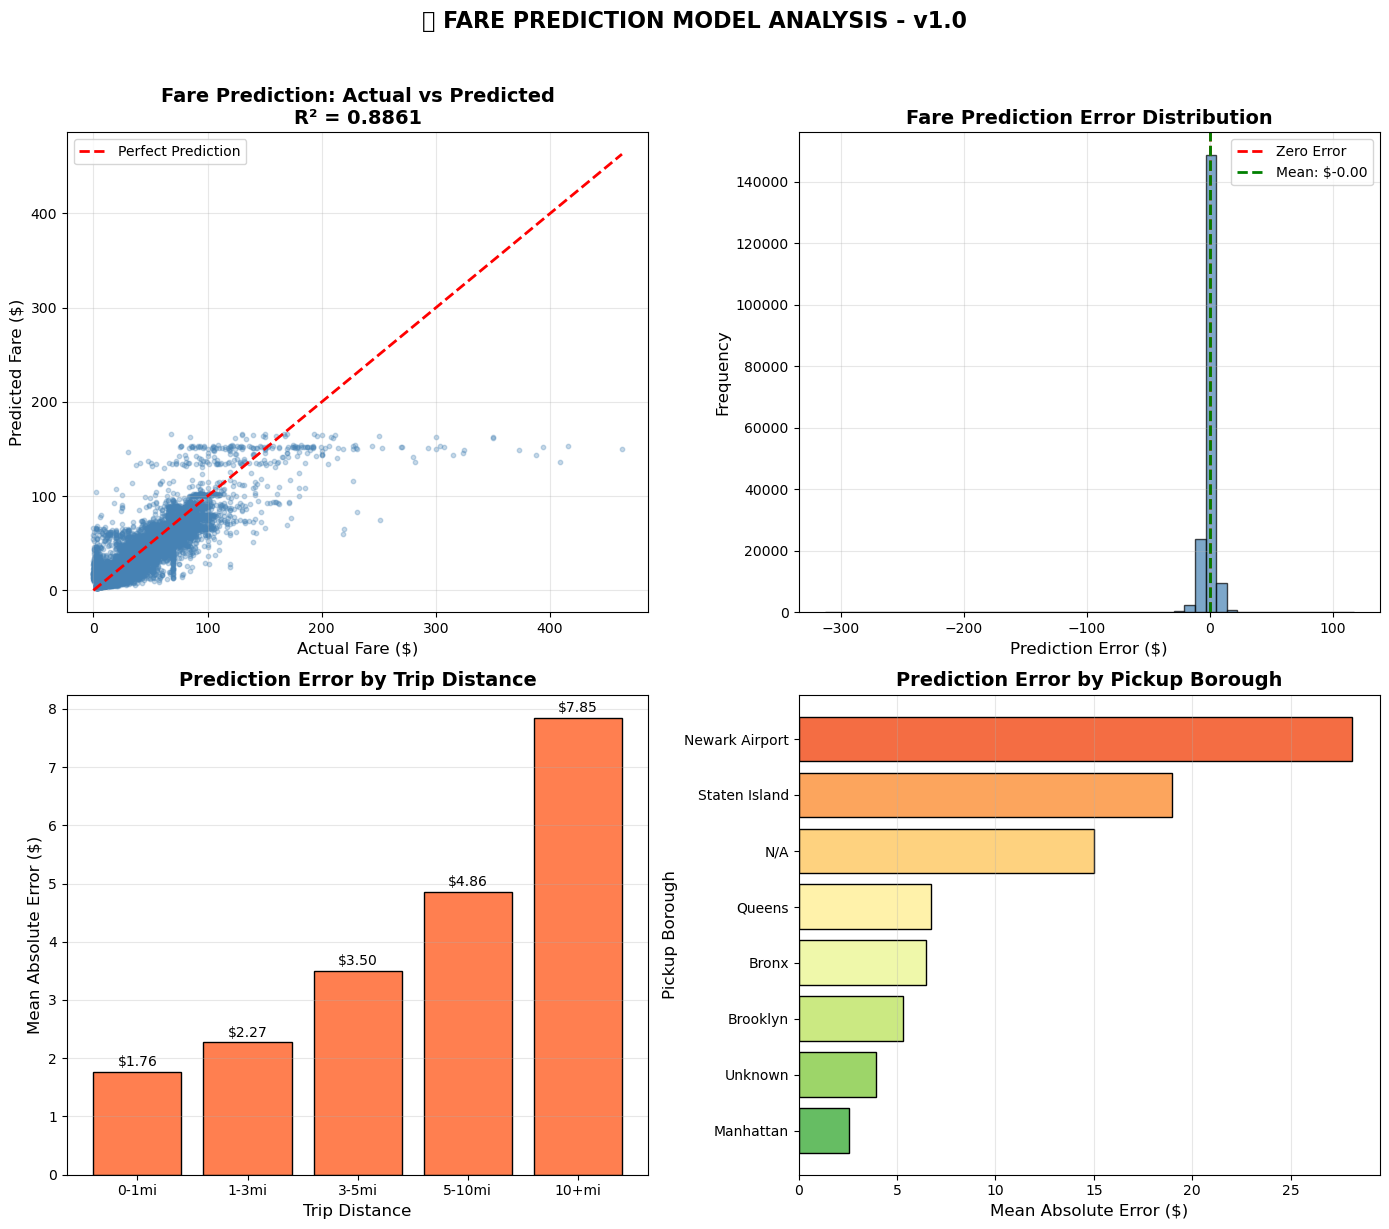

✅ Fare prediction visualization complete


In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert predictions to Pandas for visualization
print("📊 Preparing Fare Prediction visualizations...")

df_fare_viz = predictions_fare.select(
    "label", "prediction", "trip_distance_miles", "pickup_borough"
).sample(fraction=0.1, seed=42).toPandas()

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Actual vs Predicted scatter plot
ax1 = axes[0, 0]
ax1.scatter(df_fare_viz['label'], df_fare_viz['prediction'], alpha=0.3, s=10, c='steelblue')
max_val = max(df_fare_viz['label'].max(), df_fare_viz['prediction'].max())
ax1.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Fare ($)', fontsize=12)
ax1.set_ylabel('Predicted Fare ($)', fontsize=12)
ax1.set_title(f'Fare Prediction: Actual vs Predicted\nR² = {r2_fare:.4f}', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Prediction Error Distribution
ax2 = axes[0, 1]
errors = df_fare_viz['prediction'] - df_fare_viz['label']
ax2.hist(errors, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(x=0, color='red', linestyle='--', lw=2, label='Zero Error')
ax2.axvline(x=errors.mean(), color='green', linestyle='--', lw=2, label=f'Mean: ${errors.mean():.2f}')
ax2.set_xlabel('Prediction Error ($)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Fare Prediction Error Distribution', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Error by Trip Distance
ax3 = axes[1, 0]
df_fare_viz['error'] = abs(df_fare_viz['prediction'] - df_fare_viz['label'])
df_fare_viz['distance_bin'] = pd.cut(
    df_fare_viz['trip_distance_miles'], 
    bins=[0, 1, 3, 5, 10, 100], 
    labels=['0-1mi', '1-3mi', '3-5mi', '5-10mi', '10+mi']
)
error_by_distance = df_fare_viz.groupby('distance_bin')['error'].mean()
bars = ax3.bar(range(len(error_by_distance)), error_by_distance.values, color='coral', edgecolor='black')
ax3.set_xticks(range(len(error_by_distance)))
ax3.set_xticklabels(error_by_distance.index, rotation=0)
ax3.set_xlabel('Trip Distance', fontsize=12)
ax3.set_ylabel('Mean Absolute Error ($)', fontsize=12)
ax3.set_title('Prediction Error by Trip Distance', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
# Add value labels
for bar, val in zip(bars, error_by_distance.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'${val:.2f}', ha='center', fontsize=10)

# 4. Error by Borough
ax4 = axes[1, 1]
error_by_borough = df_fare_viz.groupby('pickup_borough')['error'].mean().sort_values(ascending=True)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(error_by_borough)))
ax4.barh(range(len(error_by_borough)), error_by_borough.values, color=colors, edgecolor='black')
ax4.set_yticks(range(len(error_by_borough)))
ax4.set_yticklabels(error_by_borough.index)
ax4.set_xlabel('Mean Absolute Error ($)', fontsize=12)
ax4.set_ylabel('Pickup Borough', fontsize=12)
ax4.set_title('Prediction Error by Pickup Borough', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

plt.suptitle(f'🚕 FARE PREDICTION MODEL ANALYSIS - {MODEL_VERSION}', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✅ Fare prediction visualization complete")

### 11.2 Tip Classification Visualization

StatementMeta(, 22a30dd2-db0c-4926-af7e-829bbc18c822, 28, Finished, Available, Finished)

📊 Preparing Tip Classification visualizations...


/tmp/ipykernel_6634/947381535.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tip_rate = df_tip_viz.groupby('fare_bin')['label'].agg(['mean', 'count'])
/tmp/ipykernel_6634/947381535.py:87: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from current font.
  plt.tight_layout()
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


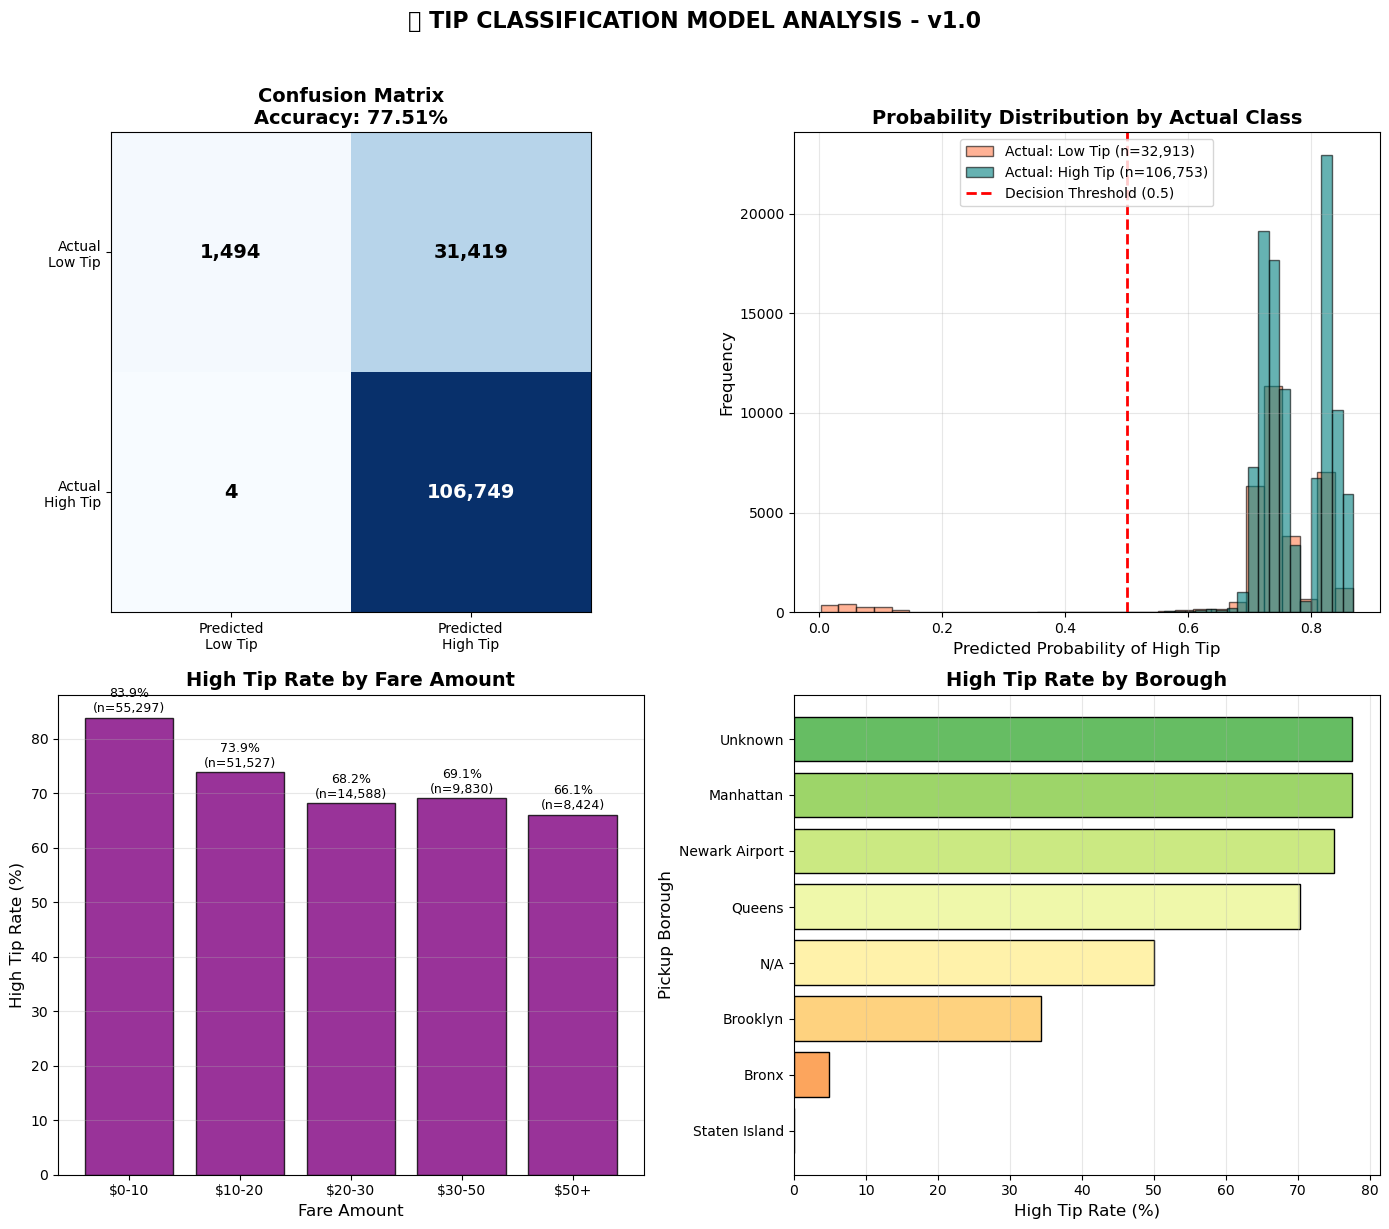

✅ Tip classification visualization complete


In [26]:
print("📊 Preparing Tip Classification visualizations...")

df_tip_viz = predictions_tip.select(
    "label", "prediction", "probability", "fare_amount", "trip_distance_miles", "pickup_borough"
).sample(fraction=0.1, seed=42).toPandas()

# Extract probability of high tip (class 1)
df_tip_viz['prob_high_tip'] = df_tip_viz['probability'].apply(lambda x: float(x[1]))

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Confusion Matrix
ax1 = axes[0, 0]
cm_data = df_tip_viz.groupby(['label', 'prediction']).size().unstack(fill_value=0)
# Ensure 2x2 matrix
if cm_data.shape != (2, 2):
    for i in [0, 1]:
        if i not in cm_data.index:
            cm_data.loc[i] = 0
        if i not in cm_data.columns:
            cm_data[i] = 0
    cm_data = cm_data.sort_index().sort_index(axis=1)

im = ax1.imshow(cm_data.values, interpolation='nearest', cmap='Blues')
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_xticklabels(['Predicted\nLow Tip', 'Predicted\nHigh Tip'])
ax1.set_yticklabels(['Actual\nLow Tip', 'Actual\nHigh Tip'])
ax1.set_title(f'Confusion Matrix\nAccuracy: {accuracy_tip:.2%}', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(2):
    for j in range(2):
        val = cm_data.values[i, j]
        color = 'white' if val > cm_data.values.max() / 2 else 'black'
        ax1.text(j, i, f'{int(val):,}', ha='center', va='center', color=color, fontsize=14, fontweight='bold')

# 2. Probability Distribution
ax2 = axes[0, 1]
low_tip_probs = df_tip_viz[df_tip_viz['label'] == 0]['prob_high_tip']
high_tip_probs = df_tip_viz[df_tip_viz['label'] == 1]['prob_high_tip']
ax2.hist(low_tip_probs, bins=30, alpha=0.6, label=f'Actual: Low Tip (n={len(low_tip_probs):,})', color='coral', edgecolor='black')
ax2.hist(high_tip_probs, bins=30, alpha=0.6, label=f'Actual: High Tip (n={len(high_tip_probs):,})', color='teal', edgecolor='black')
ax2.axvline(x=0.5, color='red', linestyle='--', lw=2, label='Decision Threshold (0.5)')
ax2.set_xlabel('Predicted Probability of High Tip', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Probability Distribution by Actual Class', fontsize=14, fontweight='bold')
ax2.legend(loc='upper center')
ax2.grid(True, alpha=0.3)

# 3. High Tip Rate by Fare Amount
ax3 = axes[1, 0]
df_tip_viz['fare_bin'] = pd.cut(
    df_tip_viz['fare_amount'], 
    bins=[0, 10, 20, 30, 50, 1000], 
    labels=['$0-10', '$10-20', '$20-30', '$30-50', '$50+']
)
tip_rate = df_tip_viz.groupby('fare_bin')['label'].agg(['mean', 'count'])
tip_rate['mean'] = tip_rate['mean'] * 100

bars = ax3.bar(range(len(tip_rate)), tip_rate['mean'].values, color='purple', edgecolor='black', alpha=0.8)
ax3.set_xticks(range(len(tip_rate)))
ax3.set_xticklabels(tip_rate.index, rotation=0)
ax3.set_xlabel('Fare Amount', fontsize=12)
ax3.set_ylabel('High Tip Rate (%)', fontsize=12)
ax3.set_title('High Tip Rate by Fare Amount', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
# Add value labels
for bar, val, cnt in zip(bars, tip_rate['mean'].values, tip_rate['count'].values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}%\n(n={cnt:,})', ha='center', fontsize=9)

# 4. High Tip Rate by Borough
ax4 = axes[1, 1]
tip_by_borough = df_tip_viz.groupby('pickup_borough')['label'].mean() * 100
tip_by_borough = tip_by_borough.sort_values(ascending=True)
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(tip_by_borough)))
ax4.barh(range(len(tip_by_borough)), tip_by_borough.values, color=colors, edgecolor='black')
ax4.set_yticks(range(len(tip_by_borough)))
ax4.set_yticklabels(tip_by_borough.index)
ax4.set_xlabel('High Tip Rate (%)', fontsize=12)
ax4.set_ylabel('Pickup Borough', fontsize=12)
ax4.set_title('High Tip Rate by Borough', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

plt.suptitle(f'💰 TIP CLASSIFICATION MODEL ANALYSIS - {MODEL_VERSION}', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✅ Tip classification visualization complete")

### 11.3 Demand Forecasting Visualization

StatementMeta(, 22a30dd2-db0c-4926-af7e-829bbc18c822, 29, Finished, Available, Finished)

📊 Preparing Demand Forecasting visualizations...


/tmp/ipykernel_6634/1775162292.py:66: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


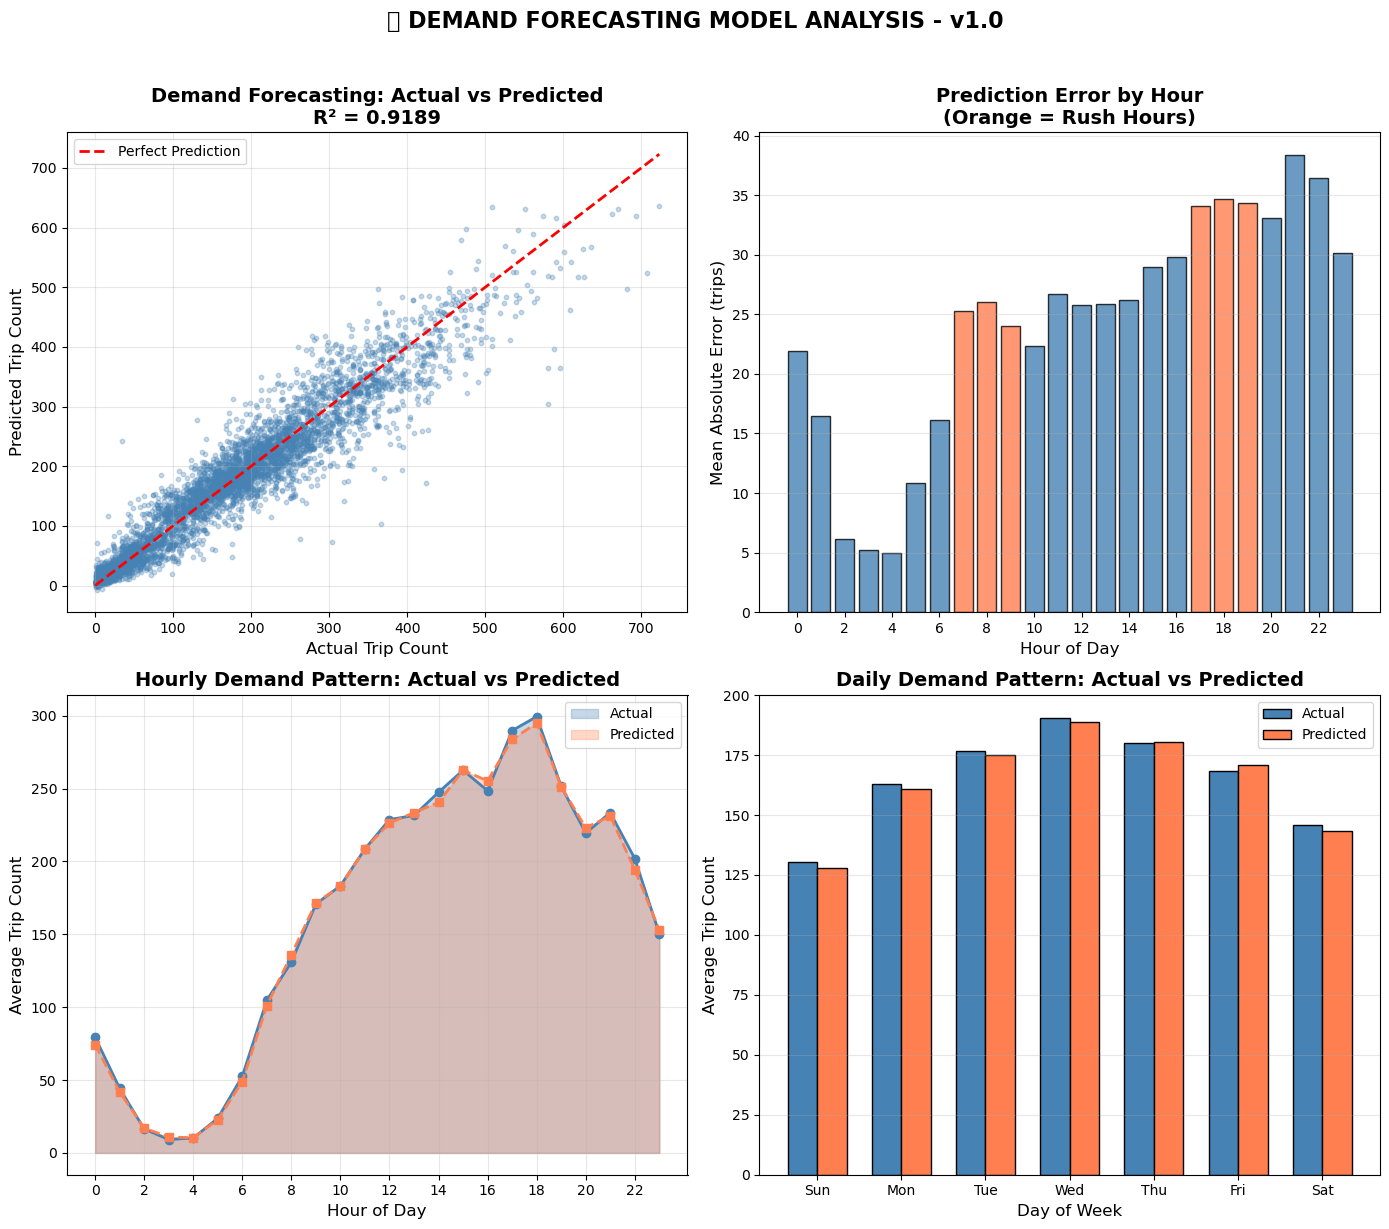

✅ Demand forecasting visualization complete


In [27]:
print("📊 Preparing Demand Forecasting visualizations...")

df_demand_viz = predictions_demand.select(
    "label", "prediction", "hour", "day_of_week", "pickup_location_sk"
).sample(fraction=0.2, seed=42).toPandas()

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Actual vs Predicted
ax1 = axes[0, 0]
ax1.scatter(df_demand_viz['label'], df_demand_viz['prediction'], alpha=0.3, s=10, c='steelblue')
max_val = max(df_demand_viz['label'].max(), df_demand_viz['prediction'].max())
ax1.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Trip Count', fontsize=12)
ax1.set_ylabel('Predicted Trip Count', fontsize=12)
ax1.set_title(f'Demand Forecasting: Actual vs Predicted\nR² = {r2_demand:.4f}', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Error by Hour
ax2 = axes[0, 1]
df_demand_viz['abs_error'] = abs(df_demand_viz['prediction'] - df_demand_viz['label'])
error_by_hour = df_demand_viz.groupby('hour')['abs_error'].mean()
colors = ['coral' if h in [7,8,9,17,18,19] else 'steelblue' for h in error_by_hour.index]
ax2.bar(error_by_hour.index, error_by_hour.values, color=colors, edgecolor='black', alpha=0.8)
ax2.set_xlabel('Hour of Day', fontsize=12)
ax2.set_ylabel('Mean Absolute Error (trips)', fontsize=12)
ax2.set_title('Prediction Error by Hour\n(Orange = Rush Hours)', fontsize=14, fontweight='bold')
ax2.set_xticks(range(0, 24, 2))
ax2.grid(True, alpha=0.3, axis='y')

# 3. Demand Pattern by Hour
ax3 = axes[1, 0]
actual_by_hour = df_demand_viz.groupby('hour')['label'].mean()
predicted_by_hour = df_demand_viz.groupby('hour')['prediction'].mean()
ax3.fill_between(actual_by_hour.index, actual_by_hour.values, alpha=0.3, color='steelblue', label='Actual')
ax3.fill_between(predicted_by_hour.index, predicted_by_hour.values, alpha=0.3, color='coral', label='Predicted')
ax3.plot(actual_by_hour.index, actual_by_hour.values, 'o-', color='steelblue', lw=2, markersize=6)
ax3.plot(predicted_by_hour.index, predicted_by_hour.values, 's--', color='coral', lw=2, markersize=6)
ax3.set_xlabel('Hour of Day', fontsize=12)
ax3.set_ylabel('Average Trip Count', fontsize=12)
ax3.set_title('Hourly Demand Pattern: Actual vs Predicted', fontsize=14, fontweight='bold')
ax3.set_xticks(range(0, 24, 2))
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Demand by Day of Week
ax4 = axes[1, 1]
day_names = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
actual_by_day = df_demand_viz.groupby('day_of_week')['label'].mean()
predicted_by_day = df_demand_viz.groupby('day_of_week')['prediction'].mean()

x = np.arange(len(actual_by_day))
width = 0.35
bars1 = ax4.bar(x - width/2, actual_by_day.values, width, label='Actual', color='steelblue', edgecolor='black')
bars2 = ax4.bar(x + width/2, predicted_by_day.values, width, label='Predicted', color='coral', edgecolor='black')
ax4.set_xlabel('Day of Week', fontsize=12)
ax4.set_ylabel('Average Trip Count', fontsize=12)
ax4.set_title('Daily Demand Pattern: Actual vs Predicted', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels([day_names[int(d)-1] if 1 <= d <= 7 else f'D{int(d)}' for d in actual_by_day.index])
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle(f'📈 DEMAND FORECASTING MODEL ANALYSIS - {MODEL_VERSION}', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✅ Demand forecasting visualization complete")

### 11.4 Model Performance Summary Dashboard

StatementMeta(, 22a30dd2-db0c-4926-af7e-829bbc18c822, 30, Finished, Available, Finished)

/tmp/ipykernel_6634/275378805.py:51: UserWarning: Glyph 128661 (\N{TAXI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_6634/275378805.py:51: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_6634/275378805.py:51: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_6634/275378805.py:51: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from current font.
  plt.tight_layout()
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128661 (\N{TAXI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/trusted-service-user/cluster-env/t

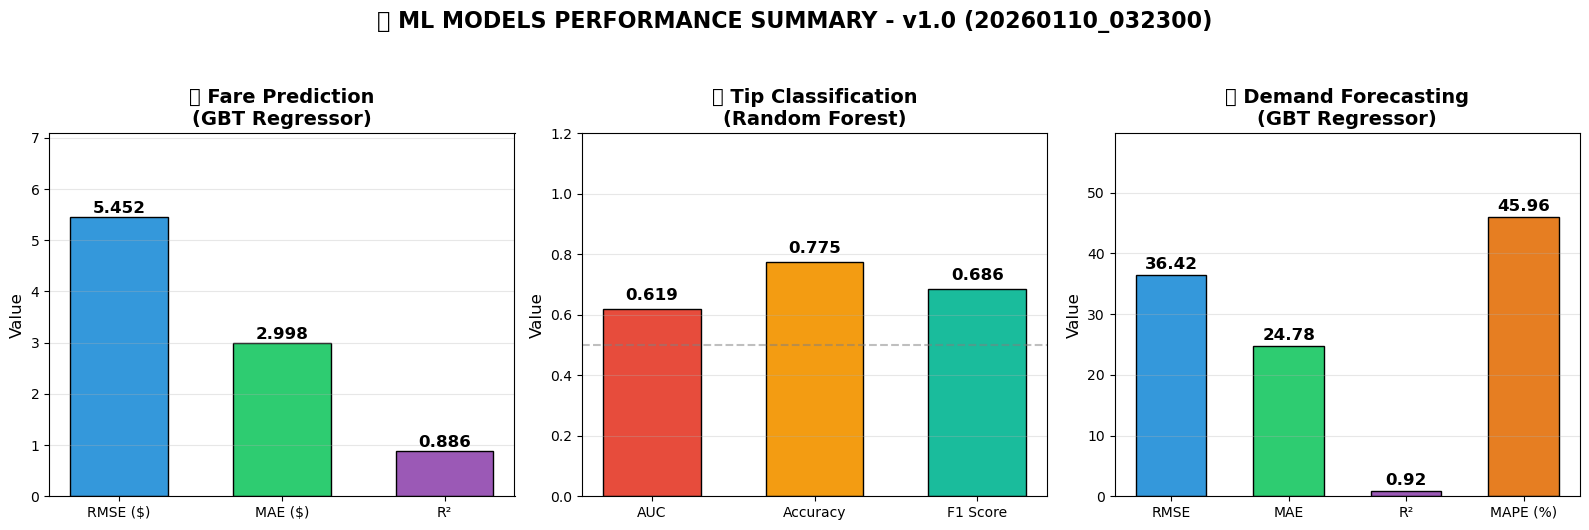

✅ Performance summary dashboard complete


In [28]:
print("📊 Creating Performance Summary Dashboard...")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Color scheme
colors_fare = ['#3498db', '#2ecc71', '#9b59b6']
colors_tip = ['#e74c3c', '#f39c12', '#1abc9c']
colors_demand = ['#3498db', '#2ecc71', '#9b59b6', '#e67e22']

# Model 1: Fare Prediction
ax1 = axes[0]
metrics_fare = ['RMSE ($)', 'MAE ($)', 'R²']
values_fare = [rmse_fare, mae_fare, r2_fare]
bars1 = ax1.bar(metrics_fare, values_fare, color=colors_fare, edgecolor='black', width=0.6)
ax1.set_title('🚕 Fare Prediction\n(GBT Regressor)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Value', fontsize=12)
for bar, val in zip(bars1, values_fare):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax1.set_ylim(0, max(values_fare) * 1.3)
ax1.grid(True, alpha=0.3, axis='y')

# Model 2: Tip Classification
ax2 = axes[1]
metrics_tip = ['AUC', 'Accuracy', 'F1 Score']
values_tip = [auc_tip, accuracy_tip, f1_tip]
bars2 = ax2.bar(metrics_tip, values_tip, color=colors_tip, edgecolor='black', width=0.6)
ax2.set_title('💰 Tip Classification\n(Random Forest)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Value', fontsize=12)
for bar, val in zip(bars2, values_tip):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1.2)
ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Baseline (0.5)')
ax2.grid(True, alpha=0.3, axis='y')

# Model 3: Demand Forecasting
ax3 = axes[2]
metrics_demand = ['RMSE', 'MAE', 'R²', 'MAPE (%)']
values_demand_plot = [rmse_demand, mae_demand, r2_demand, mape_demand]
bars3 = ax3.bar(metrics_demand, values_demand_plot, color=colors_demand, edgecolor='black', width=0.6)
ax3.set_title('📈 Demand Forecasting\n(GBT Regressor)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Value', fontsize=12)
for bar, val in zip(bars3, values_demand_plot):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{val:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax3.set_ylim(0, max(values_demand_plot) * 1.3)
ax3.grid(True, alpha=0.3, axis='y')

plt.suptitle(f'🤖 ML MODELS PERFORMANCE SUMMARY - {MODEL_VERSION} ({RUN_TIMESTAMP})', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

print("✅ Performance summary dashboard complete")

### 11.5 Save Visualization Data for Power BI


In [29]:
print("💾 Saving visualization data for Power BI...")

# 1. Model Performance Summary
model_perf_data = [
    (MODEL_VERSION, RUN_TIMESTAMP, "Fare_Prediction", "RMSE", float(rmse_fare)),
    (MODEL_VERSION, RUN_TIMESTAMP, "Fare_Prediction", "MAE", float(mae_fare)),
    (MODEL_VERSION, RUN_TIMESTAMP, "Fare_Prediction", "R2", float(r2_fare)),
    (MODEL_VERSION, RUN_TIMESTAMP, "Tip_Classification", "AUC", float(auc_tip)),
    (MODEL_VERSION, RUN_TIMESTAMP, "Tip_Classification", "Accuracy", float(accuracy_tip)),
    (MODEL_VERSION, RUN_TIMESTAMP, "Tip_Classification", "F1", float(f1_tip)),
    (MODEL_VERSION, RUN_TIMESTAMP, "Demand_Forecasting", "RMSE", float(rmse_demand)),
    (MODEL_VERSION, RUN_TIMESTAMP, "Demand_Forecasting", "MAE", float(mae_demand)),
    (MODEL_VERSION, RUN_TIMESTAMP, "Demand_Forecasting", "R2", float(r2_demand)),
    (MODEL_VERSION, RUN_TIMESTAMP, "Demand_Forecasting", "MAPE", float(mape_demand))
]

df_perf = spark.createDataFrame(model_perf_data, ["version", "timestamp", "model", "metric", "value"])
df_perf.write.format("delta").mode("append").option("mergeSchema", "true").saveAsTable("gold_ml_performance_metrics")
print("   ✅ gold_ml_performance_metrics updated")

# 2. Fare Predictions Sample
predictions_fare.select(
    F.lit(MODEL_VERSION).alias("model_version"),
    F.col("label").alias("actual_fare"),
    F.col("prediction").alias("predicted_fare"),
    F.abs(F.col("label") - F.col("prediction")).alias("error"),
    "trip_distance_miles",
    "pickup_borough"
).sample(fraction=0.01, seed=42).write.format("delta").mode("overwrite").saveAsTable("gold_ml_fare_predictions")
print("   ✅ gold_ml_fare_predictions saved")

# 3. Tip Predictions Sample
predictions_tip.select(
    F.lit(MODEL_VERSION).alias("model_version"),
    F.col("label").alias("actual_high_tip"),
    F.col("prediction").alias("predicted_high_tip"),
    "fare_amount",
    "trip_distance_miles",
    "pickup_borough"
).sample(fraction=0.01, seed=42).write.format("delta").mode("overwrite").saveAsTable("gold_ml_tip_predictions")
print("   ✅ gold_ml_tip_predictions saved")

# 4. Demand Predictions Sample
predictions_demand.select(
    F.lit(MODEL_VERSION).alias("model_version"),
    F.col("label").alias("actual_trips"),
    F.col("prediction").alias("predicted_trips"),
    "hour",
    "day_of_week",
    "pickup_location_sk"
).sample(fraction=0.05, seed=42).write.format("delta").mode("overwrite").saveAsTable("gold_ml_demand_predictions")
print("   ✅ gold_ml_demand_predictions saved")

print("\n✅ All visualization data saved!")

StatementMeta(, 22a30dd2-db0c-4926-af7e-829bbc18c822, 31, Finished, Available, Finished)

💾 Saving visualization data for Power BI...
   ✅ gold_ml_performance_metrics updated
   ✅ gold_ml_fare_predictions saved
   ✅ gold_ml_tip_predictions saved
   ✅ gold_ml_demand_predictions saved

✅ All visualization data saved!


## 12. Final Summary

In [43]:
print("=" * 90)
print("🎉 ML PIPELINE COMPLETE!")
print("=" * 90)
print(f"""
┌──────────────────────────────────────────────────────────────────────────────────────────┐
│ EXPERIMENT SUMMARY                                                                       │
├──────────────────────────────────────────────────────────────────────────────────────────┤
│ Experiment:     {EXPERIMENT_NAME:<60}             │
│ Version:        {MODEL_VERSION:<60}             │
│ Timestamp:      {RUN_TIMESTAMP:<60}             │
│ MLflow:         {'✅ Enabled' if MLFLOW_AVAILABLE else '❌ Disabled':<60}            │
├──────────────────────────────────────────────────────────────────────────────────────────┤
│ MODELS TRAINED                                                                           │
├──────────────────────────────────────────────────────────────────────────────────────────┤
│ 🚕 Fare Prediction     │ RMSE: ${rmse_fare:<8.2f} │ MAE: ${mae_fare:<8.2f} │ R²: {r2_fare:.4f}                   │
│ 💰 Tip Classification  │ AUC: {auc_tip:<9.4f}  │ Acc: {accuracy_tip:<9.4f} │ F1: {f1_tip:.4f}                   │
│ 📈 Demand Forecasting  │ RMSE: {rmse_demand:<9.2f} │ MAE: {mae_demand:<9.2f} │ R²: {r2_demand:.4f}                   │
├──────────────────────────────────────────────────────────────────────────────────────────┤
│ ARTIFACTS SAVED                                                                          │
├──────────────────────────────────────────────────────────────────────────────────────────┤
│ 📁 Models:      Files/ml_models/*/                                                       │
│ 📋 Tables:      gold_ml_model_registry                                                   │
│                 gold_ml_performance_metrics                                              │
│                 gold_ml_fare_predictions                                                 │
│                 gold_ml_tip_predictions                                                  │
│                 gold_ml_demand_predictions                                               │
└──────────────────────────────────────────────────────────────────────────────────────────┘
""")
print("=" * 90)
print("   Next Step: Run 05_Power_BI_Integration notebook or view results in Power BI")
print("=" * 90)

StatementMeta(, 22a30dd2-db0c-4926-af7e-829bbc18c822, 45, Finished, Available, Finished)

🎉 ML PIPELINE COMPLETE!

┌──────────────────────────────────────────────────────────────────────────────────────────┐
│ EXPERIMENT SUMMARY                                                                       │
├──────────────────────────────────────────────────────────────────────────────────────────┤
│ Experiment:     NYC_Taxi_ML_Models                                                       │
│ Version:        v1.0                                                                     │
│ Timestamp:      20260110_032300                                                          │
│ MLflow:         ✅ Enabled                                                               │
├──────────────────────────────────────────────────────────────────────────────────────────┤
│ MODELS TRAINED                                                                           │
├──────────────────────────────────────────────────────────────────────────────────────────┤
│ 🚕 Fare Prediction     │ RMSE: $5.45     │ MA